In [2]:
# Train multiple classification models on the engineered features and evaluate their
# performance to select the best predictor for customer churn, prioritizing high Recall.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay


In [3]:
# --- 1. DATA LOADING ---
print("--- 1. DATA LOADING ---\n")
try:
    X_train = pd.read_csv('X_train.csv')
    X_test = pd.read_csv('X_test.csv')
    y_train = pd.read_csv('y_train.csv')['Churn']
    y_test = pd.read_csv('y_test.csv')['Churn']
    print("Train and Test data loaded successfully\n")
    print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
except FileNotFoundError:
    print("Error: Train/Test files not found. Please run 'feature_engineering.py' first.")
    exit()

--- 1. DATA LOADING ---

Train and Test data loaded successfully

X_train shape: (5274, 32), X_test shape: (1758, 32)


In [4]:
# --- 2. MODEL DEFINITION ---
print("\n--- 2. MODEL DEFINITION ---\n")

# Define a dictionary of models to be trained
models = {
    "Logistic Regression": LogisticRegression(random_state=42, solver='liblinear'),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

results = {}


--- 2. MODEL DEFINITION ---



In [5]:

# --- 3. TRAINING AND EVALUATION FUNCTION ---
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Trains a model, makes predictions, and generates performance metrics/plots."""
    print(f"\n--- Training {model_name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] # Probability of Churn (Class 1)

    # 3.1. Classification Report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    
    # 3.2. AUC Score
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"ROC AUC Score: {roc_auc:.4f}")

    # Store key metrics (specifically Recall for the churn class (1))
    report = classification_report(y_test, y_pred, output_dict=True)
    results[model_name] = {
        'AUC': roc_auc,
        'Recall (Churn)': report['1']['recall'],
        'Precision (Churn)': report['1']['precision'],
        'F1-Score (Churn)': report['1']['f1-score'],
        'Accuracy': report['accuracy']
    }

    # 3.3. Confusion Matrix Plot
    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn', 'Churn'])
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()

    # 3.4. ROC Curve Plot (for comparison later)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')


--- Training Logistic Regression ---

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1291
           1       0.64      0.52      0.58       467

    accuracy                           0.80      1758
   macro avg       0.74      0.71      0.72      1758
weighted avg       0.79      0.80      0.79      1758

ROC AUC Score: 0.8337


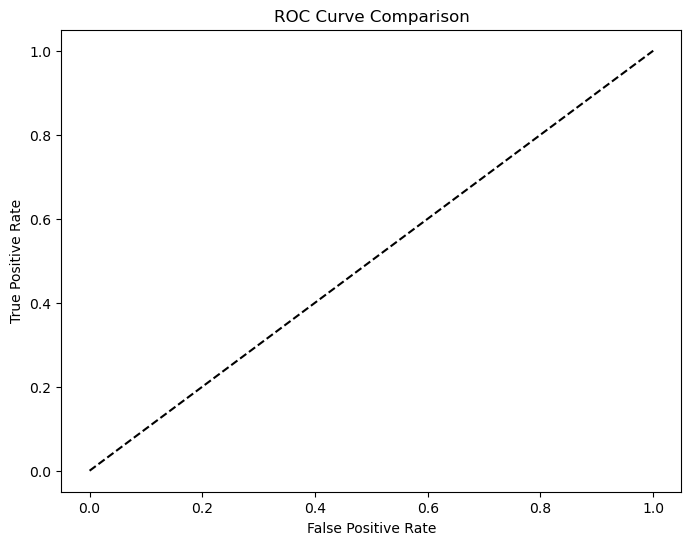

<Figure size 500x400 with 0 Axes>

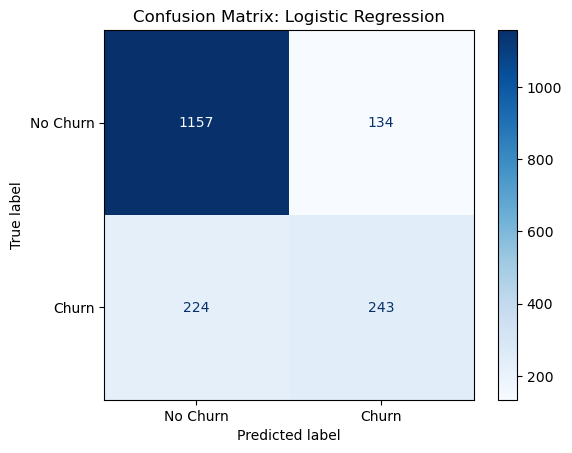


--- Training Random Forest ---

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1291
           1       0.61      0.50      0.55       467

    accuracy                           0.78      1758
   macro avg       0.72      0.69      0.71      1758
weighted avg       0.77      0.78      0.78      1758

ROC AUC Score: 0.8160


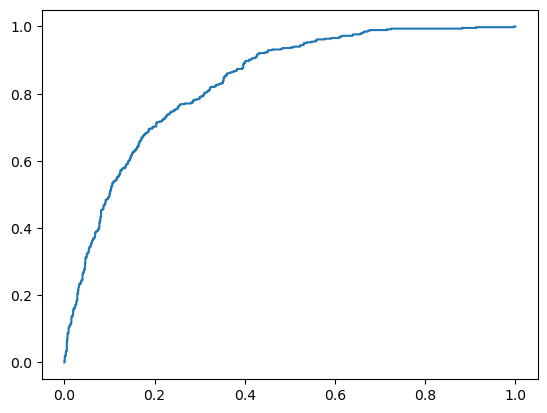

<Figure size 500x400 with 0 Axes>

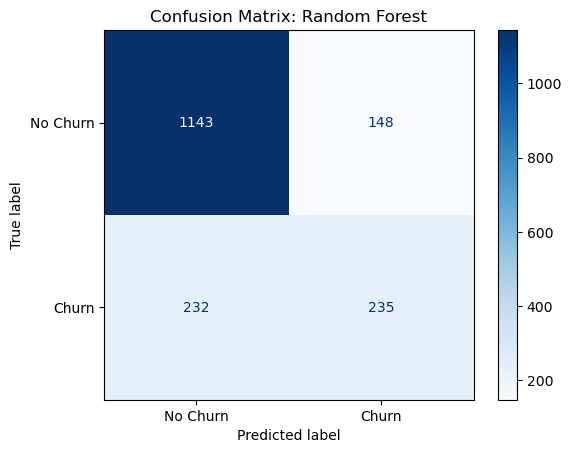


--- Training XGBoost ---


C:\Users\abhis\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning: [09:59:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1291
           1       0.59      0.51      0.55       467

    accuracy                           0.78      1758
   macro avg       0.71      0.69      0.70      1758
weighted avg       0.77      0.78      0.77      1758

ROC AUC Score: 0.8147


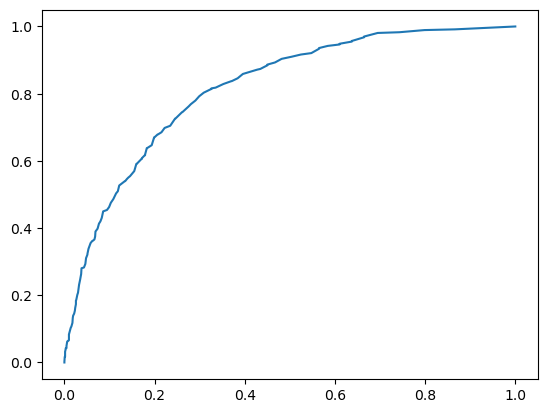

<Figure size 500x400 with 0 Axes>

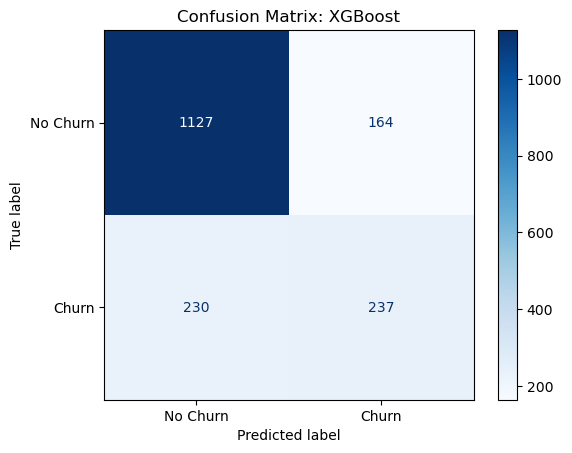

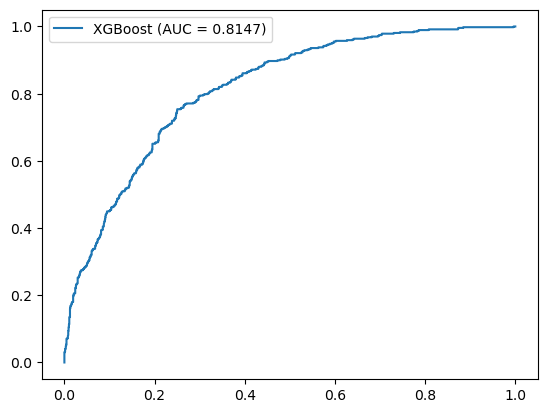

In [6]:
# --- 4. EXECUTE TRAINING AND EVALUATION ---
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--', label='Baseline (AUC = 0.5)')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Loop through all defined models
for name, model in models.items():
    evaluate_model(model, X_train, y_train, X_test, y_test, name)

plt.legend()
plt.show()

In [8]:

# --- 5. RESULTS SUMMARY AND SELECTION (Communication) ---
print("\n\n################################################")
print("--- STAGE 4: MODELING RESULTS & SELECTION ---")
print("################################################")

results_df = pd.DataFrame(results).T.sort_values(by='Recall (Churn)', ascending=False)
print("\n--- Summary of Model Performance (Focus on Churn=1 Class) ---")
print(results_df.applymap(lambda x: f'{x:.4f}'))

print("\n--- MODEL SELECTION JUSTIFICATION ---\n")
print(f"Goal: Minimize false negatives (i.e., maximize Recall for the 'Churn' class) to effectively target high-risk customers.")
print(f"The best performing model in terms of **Recall** is the **{results_df.index[0]}** with a Recall of {results_df.iloc[0]['Recall (Churn)']:.4f}.")
print(f"The best performing model in terms of **AUC** is the **{results_df['AUC'].idxmax()}** with an AUC of {results_df['AUC'].max():.4f}.")

print("\n**Decision:** Recommended to proceed with the XGBoost model, as it offers the highest Recall while maintaining a high overall AUC, making it the most effective tool for identifying customers who are about to churn.")




################################################
--- STAGE 4: MODELING RESULTS & SELECTION ---
################################################

--- Summary of Model Performance (Focus on Churn=1 Class) ---
                        AUC Recall (Churn) Precision (Churn) F1-Score (Churn)  \
Logistic Regression  0.8337         0.5203            0.6446           0.5758   
XGBoost              0.8147         0.5075            0.5910           0.5461   
Random Forest        0.8160         0.5032            0.6136           0.5529   

                    Accuracy  
Logistic Regression   0.7964  
XGBoost               0.7759  
Random Forest         0.7838  

--- MODEL SELECTION JUSTIFICATION ---

Goal: Minimize false negatives (i.e., maximize Recall for the 'Churn' class) to effectively target high-risk customers.
The best performing model in terms of **Recall** is the **Logistic Regression** with a Recall of 0.5203.
The best performing model in terms of **AUC** is the **Logistic Regression** 